# Test your Models
This notebook is for testing the outputs of your models on various inputs.

### Imports

In [6]:
import numpy as np
import pandas as pd
import os
import json
from pathlib import Path
from tqdm import tqdm
import random
import torch
from torch import nn, optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader, random_split
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import lightning as L
# necessary cuda version on your system
print(torch.version.cuda)

#!pip install partitura miditok transformers[torch]

from torch.nn import functional as F
from transformers import GPT2LMHeadModel, AutoConfig, Trainer, TrainingArguments
from transformers.optimization import AdamW 
from transformers import pipeline, GenerationConfig, EarlyStoppingCallback


import partitura as pt
from miditok import Structured, TokenizerConfig
from miditok.data_augmentation import augment_dataset
from miditok.pytorch_data import DatasetMIDI, DataCollator
from miditok.pytorch_data import split_files_for_training
#!pip install pretty_midi jupyterlab fluidsynth
#!sudo apt-get install fluidsynth # you need program as well as package - see pretty-midi github
from IPython.display import Audio
#!pip install wandb

from pretty_midi import PrettyMIDI 
import pypianoroll
import matplotlib.pyplot as plt

import os
import scipy.io.wavfile as wavfile
#!pip install soundfile
import soundfile as sf
import matplotlib.pyplot as plt
# seed random module
L.seed_everything(21)



Seed set to 21


11.8


21

## Load model and tokenizer

In [41]:
tokenizer_path = Path("data", "tokenizer", "tokenizer.json")

models = ["model/gpt-2/bs24-lr1e-4-overlap-0-emb_d-512-len-midi-300-tok16","model/gpt-2/bs10-lr1e-4-overlap-1-emb_d-512-len-midi-300-tok16-new", "model/gpt-2/bs10-bos-only-best","model/gpt-2/bs10-bos-augmented-new"]
model_names = ["baseline", "baseline_olap", "bos_only", "bos_aug"]
i = 0
model = GPT2LMHeadModel.from_pretrained(models[i])

# load tokenizer if it already exists
if os.path.exists(tokenizer_path):
    tokenizer = Structured(params=tokenizer_path)
    
model.eval()

NUM_NOTES = 100 # length of ouput (w.o. input)

gen_config = GenerationConfig(bos_token_id=1,
                            max_new_tokens=(4*NUM_NOTES)+1, # +1 for bos token
                            do_sample=True, # False = greedy generation
                            temperature=0.95, 
                            #top_k = 50,
                            top_p=0.95,  
                            #num_beam_groups=2, 
                            #num_beams = 1, # 1 = beam search disabled                         
                            #diversity_penalty= 2.5, # for beam search, needs beam-groups
                            #early_stopping=True, 
                            #repetition_penalty=1.5,
                            #no_repeat_ngram_size=4, # ? no token is ever repeated
                            eos_token_id=2,
                            pad_token_id=0,
                            )


/home/seb/miniforge3/envs/bac/lib/python3.11/site-packages/miditok/midi_tokenizer.py:3252: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  self.config = TokenizerConfig()
/home/seb/miniforge3/envs/bac/lib/python3.11/site-packages/miditok/classes.py:702: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  return cls(**input_dict, **kwargs)


### Generate with inputs

In [42]:
# generation with input
    
for i,m in enumerate(models):
    model = GPT2LMHeadModel.from_pretrained(m)
    model.eval()
    input_paths = [None,
                Path("data/inputs/midi_test/I-II-V_fmaj.mid"),
                Path("data/inputs/midi_test/arpeggio_cmaj.mid"),
                Path("data/inputs/midi_test/single_chord_cmaj.mid"),
                Path("data/inputs/midi_test/cantaloupe_4.mid"),
                Path("data/inputs/midi_test/one_note_samba_4.mid"),
                Path("data/inputs/midi_test/sentimental_4.mid"),
                Path("data/inputs/midi_test/turnaround_4.mid"),
                Path("data/inputs/midi_test/walking_blues_4.mid"),
                ]


    for inp in input_paths:
        print(f"Generating with {inp} as input...")
        if inp == None:
            input_tokens = torch.tensor([[1]])
            inp = "data/inputs/midi_test/no_input.mid"
        else:
            input_tokens = tokenizer.encode(inp,)
            input_tokens = torch.concat((torch.tensor([[1]]),torch.tensor(input_tokens)),dim=1) # add bos token
        with torch.no_grad():
            out_in = model.generate(inputs=input_tokens, generation_config=gen_config)   
        out = tokenizer.tokens_to_midi(tokens=out_in)
        fpath = str(inp)[:-4] + f"_{i}_{model_names[i]}_out.mid"
        out.dump_midi(fpath)
        midi_data = PrettyMIDI(midi_file=fpath, initial_tempo=100)
        audio_data = midi_data.fluidsynth(fs=44100, sf2_path=os.path.join("data","soundfont","SC55_zzdenis_v0.5.sf2"))
        wav_path = f"{fpath[:-3]}wav"
        wavfile.write(wav_path,44100,audio_data)

Generating with None as input...


/tmp/ipykernel_35106/81925629.py:28: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  out = tokenizer.tokens_to_midi(tokens=out_in)


Generating with data/inputs/midi_test/I-II-V_fmaj.mid as input...
Generating with data/inputs/midi_test/arpeggio_cmaj.mid as input...
Generating with data/inputs/midi_test/single_chord_cmaj.mid as input...
Generating with data/inputs/midi_test/cantaloupe_4.mid as input...
Generating with data/inputs/midi_test/one_note_samba_4.mid as input...
Generating with data/inputs/midi_test/sentimental_4.mid as input...
Generating with data/inputs/midi_test/turnaround_4.mid as input...
Generating with data/inputs/midi_test/walking_blues_4.mid as input...
Generating with None as input...
Generating with data/inputs/midi_test/I-II-V_fmaj.mid as input...
Generating with data/inputs/midi_test/arpeggio_cmaj.mid as input...
Generating with data/inputs/midi_test/single_chord_cmaj.mid as input...
Generating with data/inputs/midi_test/cantaloupe_4.mid as input...
Generating with data/inputs/midi_test/one_note_samba_4.mid as input...
Generating with data/inputs/midi_test/sentimental_4.mid as input...
Genera

## Compare tokenizers

Here you can compare the effects of different tokenizer settings (f.e time resolution).

In [43]:
start = 904
end = 1000

pm_8 = PrettyMIDI("data/example/tokenizer_test/midi_1_tokenized_tok8.mid")
track_8 = pypianoroll.from_pretty_midi(pm_8)
track_8 = track_8.trim(start,end)
pm_16 = PrettyMIDI("data/example/tokenizer_test/midi_1_tokenized_tok16.mid")
track_16 = pypianoroll.from_pretty_midi(pm_16)
track_16 = track_16.trim(start,end)
pm_raw = PrettyMIDI("data/example/tokenizer_test/0001.mid")
track_raw = pypianoroll.from_pretty_midi(pm_raw)
track_raw = track_raw.trim(start-3,end-3)

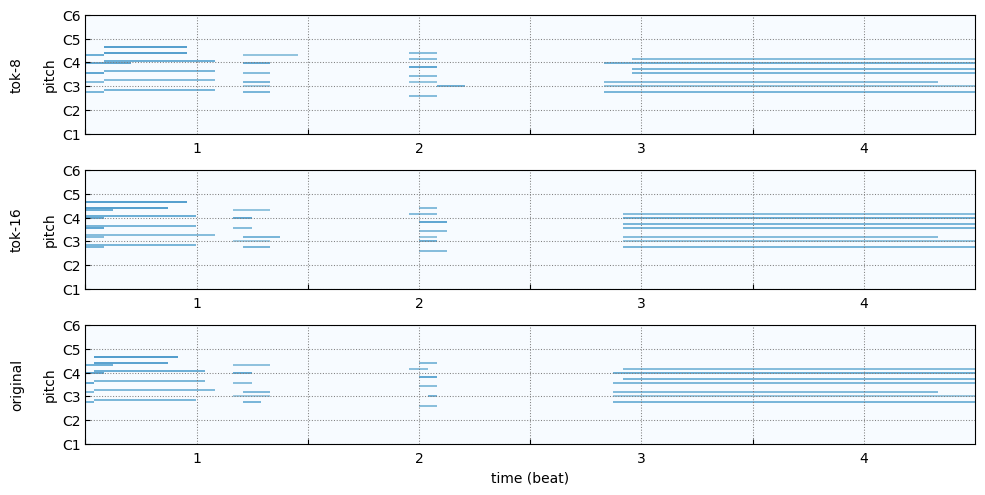

In [44]:
fig, axes = plt.subplots(3, 1, figsize=(10, 5))

pypianoroll.plot(track_8, axs= [axes[0]],track_label="off")
pypianoroll.plot(track_16, axs= [axes[1]],track_label="off")
pypianoroll.plot(track_raw, axs= [axes[2]],track_label="off")

axes[0].set_ylabel("tok-8\n\npitch")
axes[0].set_xlabel(None)
axes[1].set_ylabel("tok-16\n\npitch")
axes[1].set_xlabel(None)
axes[2].set_ylabel("original\n\npitch")
plt.tight_layout()
axes[0].set_ylim((36,96))
axes[1].set_ylim((36,96))
axes[2].set_ylim((36,96))
axes[0].grid(which='both', axis='both', linestyle=':', color='gray', linewidth=0.75)
axes[1].grid(which='both', axis='both', linestyle=':', color='gray', linewidth=0.75)
axes[2].grid(which='both', axis='both', linestyle=':', color='gray', linewidth=0.75)



## Visualize Experiments
A function to visualize outputs with pianorolls.

In [45]:
def plot_comparison( model_outputs: list[str],model_names_: list[str],input: str = None, x_lim: tuple = None):
    """function plotting all model outputs together with input in a single piano roll plot

    Args:
        model_outputs (list[str]): path to model ouput midis
        model_names_ (list[str]): list of model names for correct labels
        input (str): path to input midi if there is input, default: None
        """
    paths = model_outputs
    n_plots = len(model_outputs)
    names = model_names_.copy()
    if input is not None:
        n_plots+=1
        paths.insert(0,input)
        names.insert(0,"Input")        
    fig, axes = plt.subplots(n_plots, 1, figsize=(8, 2*n_plots))
    for i,path in enumerate(paths):
        pm = PrettyMIDI(path)
        track = pypianoroll.from_pretty_midi(pm)
        pypianoroll.plot(track, axs= [axes[i]],track_label="off")
        axes[i].set_ylabel(names[i])
        axes[i].set_xlabel(None)
        axes[i].set_ylim((36,96))
        if x_lim is not None:
            axes[i].set_xlim(x_lim)
        else:
            axes[i].set_xlim((0,500))
        axes[i].grid(which='both', axis='both', linestyle=':', color='gray', linewidth=0.75)      
    axes[i].set_xlabel("Beats")
    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [46]:
input_path = "data/inputs/midi_test/arpeggio_cmaj.mid"
prefix = "arpeggio_cmaj_"
folder = "data/inputs/midi_test/"
outputs = []
for filename in os.listdir(folder):
    if filename.startswith(prefix):
        if filename.endswith(".mid"):
            outputs.append(os.path.join(folder,filename))
outputs = sorted(outputs)
outputs

['data/inputs/midi_test/arpeggio_cmaj_0_baseline_out.mid',
 'data/inputs/midi_test/arpeggio_cmaj_1_baseline_olap_out.mid',
 'data/inputs/midi_test/arpeggio_cmaj_2_bos_only_out.mid',
 'data/inputs/midi_test/arpeggio_cmaj_3_bos_aug_out.mid']

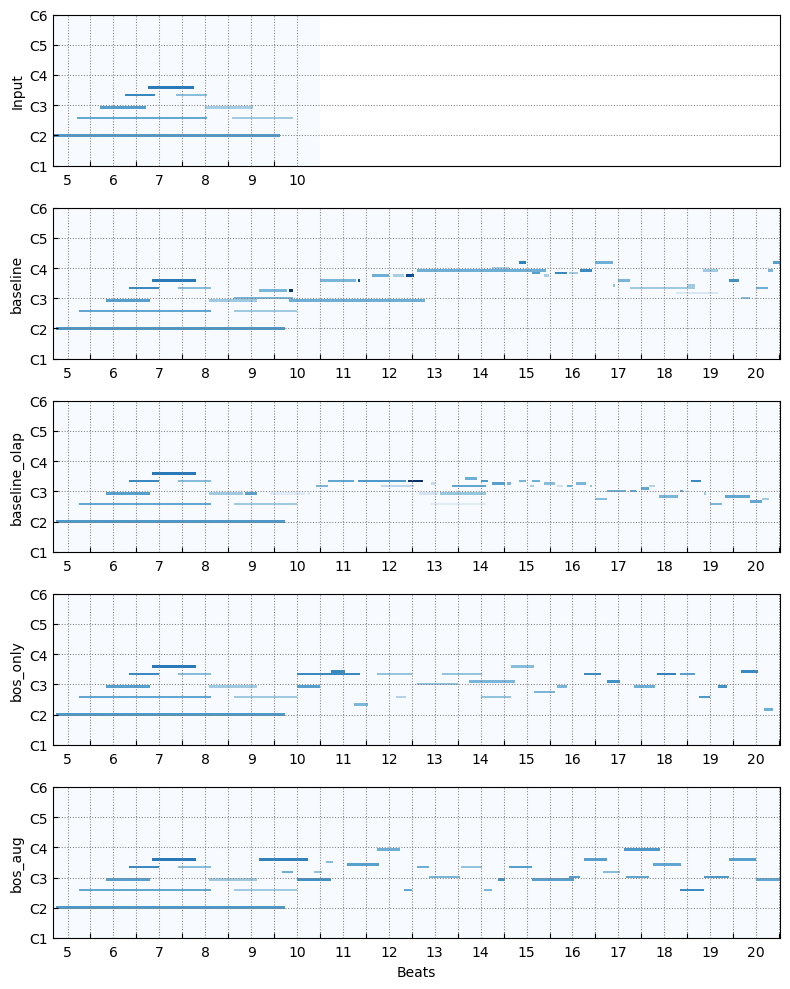

In [47]:
plot_comparison(outputs,model_names,input_path, x_lim=(100,480))

In [48]:
model_names

['baseline', 'baseline_olap', 'bos_only', 'bos_aug']

### Experimental visualization
This visualization compares the output of a model with the ground truth (e.g. give 4 bars of a piece as input and compare the next 4 bars of the model output with the groun truth). This is only an experimental visualization, as we do not expect the models to continue the input pieces exactly as they really are. (They have never seen them during training.)

Matching notes are colored red.

['data/inputs/midi_test/turnaround_4_0_baseline_out.mid', 'data/inputs/midi_test/turnaround_4_1_baseline_olap_out.mid', 'data/inputs/midi_test/turnaround_4_2_bos_only_out.mid', 'data/inputs/midi_test/turnaround_4_3_bos_aug_out.mid']


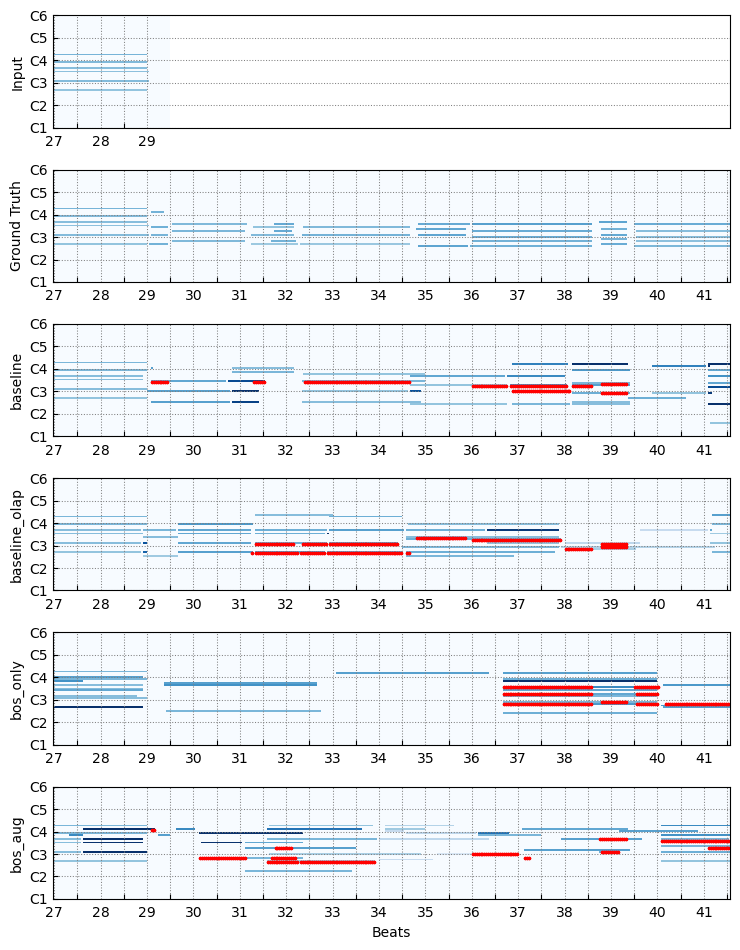

In [49]:
def plot_comparison_bos( model_outputs: list[str],model_names_: list[str],input4: str ,input8: str , x_lim: tuple = None):
    """function plotting all model outputs together with input in a single piano roll plot

    Args:
        model_outputs (list[str]): path to model ouput midis
        model_names_ (list[str]): list of model names for correct labels
        input4 (str): path to 4-bars input midi if there is input, 
        input4 (str): path to 8-bars input midi if there is input, 
        """
    paths = model_outputs
    n_plots = len(model_outputs)
    names = model_names_.copy()
    n_plots+=2
    paths.insert(0,input8)
    paths.insert(0,input4)
    names.insert(0, "Ground Truth")
    names.insert(0,"Input")        
    fig, axes = plt.subplots(n_plots, 1, figsize=(7.5,1.6*n_plots))
    
    pm_input8 = PrettyMIDI(input8)
    track_input8 = pypianoroll.from_pretty_midi(pm_input8)
    ground_truth_roll = track_input8.tracks[0].pianoroll
    
    pm_input4 = PrettyMIDI(input4)
    track_input4 = pypianoroll.from_pretty_midi(pm_input4)
    input4_roll = track_input4.tracks[0].pianoroll
    last_note_index = np.max(np.nonzero(np.any(input4_roll > 0, axis=1)))
    input_4_len = len(input4_roll[:last_note_index + 1, :])
    
    for i,path in enumerate(paths):
        pm = PrettyMIDI(path)
        track = pypianoroll.from_pretty_midi(pm)
        model_roll = track.tracks[0].pianoroll
        pypianoroll.plot(track, axs= [axes[i]],track_label="off")
        axes[i].set_ylabel(names[i])
        axes[i].set_xlabel(None)
        axes[i].set_ylim((36,96))
        if x_lim is not None:
            axes[i].set_xlim((input_4_len-50,input_4_len+300))
        else:
            axes[i].set_xlim((0,500))
        axes[i].grid(which='both', axis='both', linestyle=':', color='gray', linewidth=0.75)      
        if i > 1:
            if model_roll.shape != ground_truth_roll.shape:
                min_length = min(model_roll.shape[0], ground_truth_roll.shape[0])
                model_roll = model_roll[:min_length, :]
                ground_truth_roll = ground_truth_roll[:min_length, :]
            matching_indices = np.where((model_roll[input_4_len:] > 0) & (ground_truth_roll[input_4_len:] > 0))
            for idx in zip(*matching_indices):
                axes[i].plot([idx[0] + input_4_len, idx[0] + input_4_len], [idx[1], idx[1]], 'r.', markersize=3)

    axes[i].set_xlabel("Beats")
   

    plt.tight_layout()
    plt.show()
    plt.close()
    
## enter prefix of file you want to visualize
prefix = "turnaround_4_"
#prefix = "sentimental_4_"
#prefix = "walking_blues_4_"
input_path = f"data/inputs/midi_test/{prefix[:-1]}.mid"
input_path8 = f"data/inputs/midi_test/eight_bars/{prefix[:-2]}8.mid"
folder = "data/inputs/midi_test/"
outputs = []
for filename in os.listdir(folder):
    if filename.startswith(prefix):
        if filename.endswith(".mid"):
            outputs.append(os.path.join(folder,filename))
print(sorted(outputs))
outputs = sorted(outputs)
plot_comparison_bos(outputs,model_names,input4=input_path,input8=input_path8, x_lim=(600,900))